# TensorFlow Rotator Tutorial

The TensorFlow Sequential Classifier is a machine learning model implemented using the Sequential API in TensorFlow, built with the Keras neural networks API. It is designed for the task of classification, which involves assigning predefined labels or categories to input data.

# Import Librairies

In [ ]:
# Third-Party Librairies
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2

# Google Colab - if want to train your model in Google Colab using the Google GPU
from google.colab import drive

# Mount Drive

In [ ]:
drive.mount('/content/drive')

os.chdir('Path to your training data repository')

Mounted at /content/drive


# Load Images

In [ ]:
# Define constants
DATA_DIR = 'Path to the pictures repository'
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 5  # Your number of classes
BATCH_SIZE = 32

In [ ]:
def load_images_and_labels(data_dir):
    images = []
    labels = []
    num_images_per_class = {}

    class_mapping = {'0': 0, '90': 1, '180': 2, '270': 3, 'empty': 4}  # Mapping of your classes

    for class_folder in glob(os.path.join(data_dir, '*')):
        class_label = os.path.basename(class_folder)
        if class_label not in class_mapping:
            continue
        class_label = class_mapping[class_label]

        # Count the number of images in each class folder
        num_images = len(glob(os.path.join(class_folder, '*.jpg')))
        num_images_per_class[class_label] = num_images

        for img_path in glob(os.path.join(class_folder, '*.jpg')):
            image = cv2.imread(img_path)
            image = cv2.resize(image, IMAGE_SIZE)
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels), num_images_per_class

images, labels, num_images_per_class = load_images_and_labels(DATA_DIR)

# Output the number of images in each class folder
for class_label, num_images in num_images_per_class.items():
    print(f"Class {class_label}: {num_images} images")

Class 4: 200 images
Class 0: 340 images
Class 3: 440 images
Class 2: 440 images
Class 1: 340 images


# Prepare Training

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)

In [ ]:
# Load pre-trained model - if needed
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Model definition
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                      

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

In [ ]:
# Fit the augmentation method to your data
train_datagen.fit(X_train)

In [ ]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 30:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.5
    return lr

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train

In [ ]:
# Train the model with callbacks
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) / BATCH_SIZE,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
44/44 [==============================] - 22s 417ms/step - loss: 2.1317 - accuracy: 0.6406 - val_loss: 2.1755 - val_accuracy: 0.6932 - lr: 1.0000e-04
Epoch 2/100
44/44 [==============================] - 18s 399ms/step - loss: 1.6591 - accuracy: 0.7259 - val_loss: 1.7080 - val_accuracy: 0.6903 - lr: 1.0000e-04
Epoch 3/100
44/44 [==============================] - 18s 396ms/step - loss: 1.5908 - accuracy: 0.7521 - val_loss: 1.3489 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/100
44/44 [==============================] - 17s 381ms/step - loss: 1.5226 - accuracy: 0.7678 - val_loss: 1.4325 - val_accuracy: 0.7528 - lr: 1.0000e-04
Epoch 5/100
44/44 [==============================] - 17s 387ms/step - loss: 1.4571 - accuracy: 0.7834 - val_loss: 1.3375 - val_accuracy: 0.8153 - lr: 1.0000e-04
Epoch 6/100
44/44 [==============================] - 18s 407ms/step - loss: 1.4080 - accuracy: 0.8068 - val_loss: 1.3030 - val_accuracy: 0.8239 - lr: 1.0000e-04
Epoch 7/100
44/44 [===============

# Visualise Training

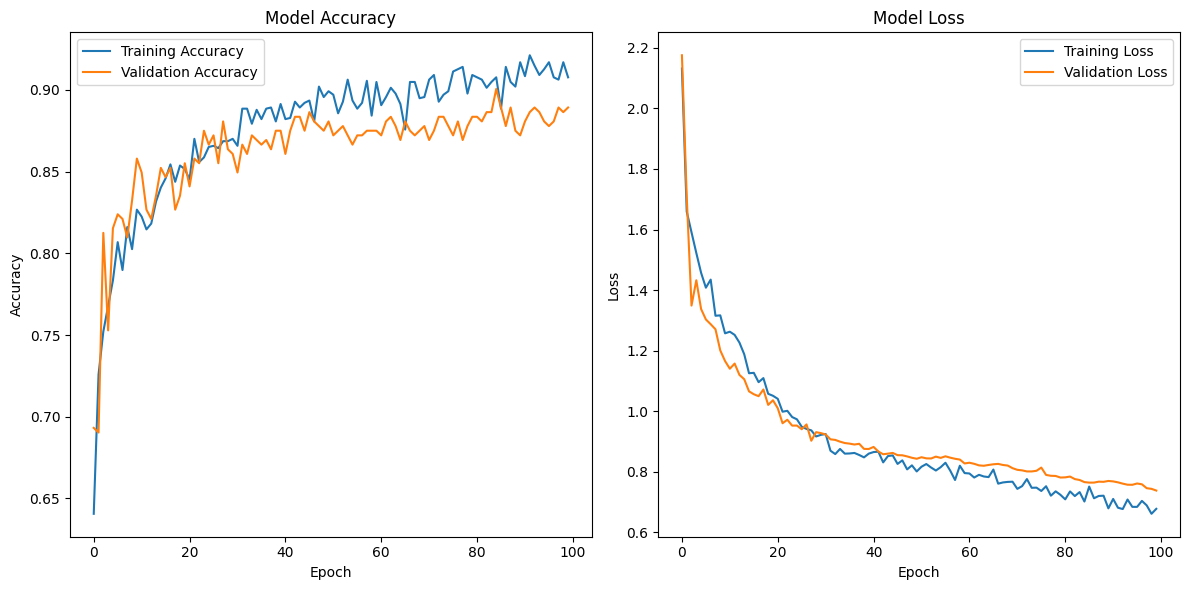

In [ ]:
# Visualize training results
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualise Accuracy during training

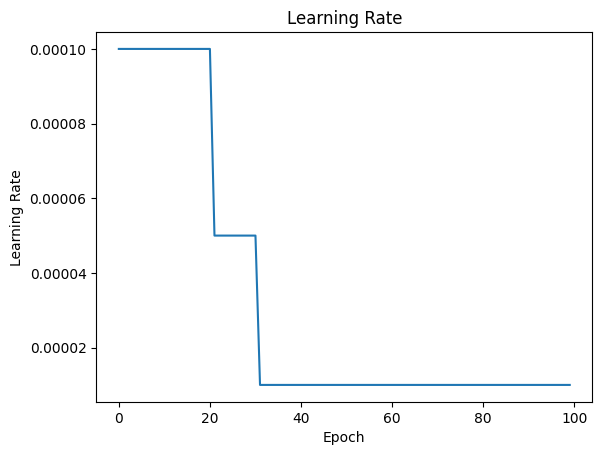

11/11 [==============================] - 2s 95ms/step


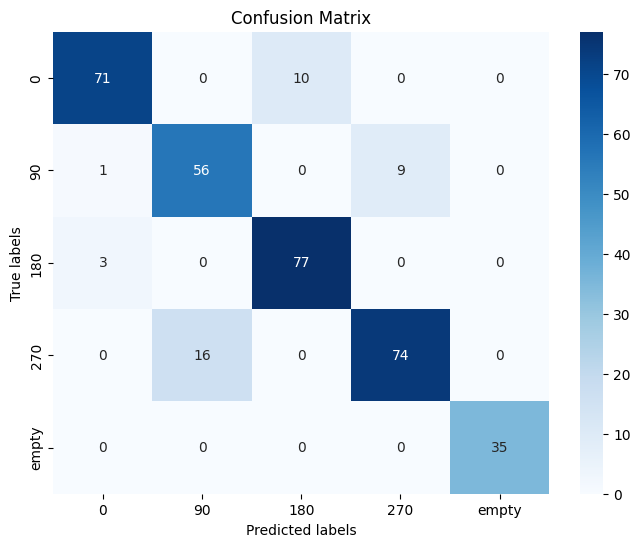

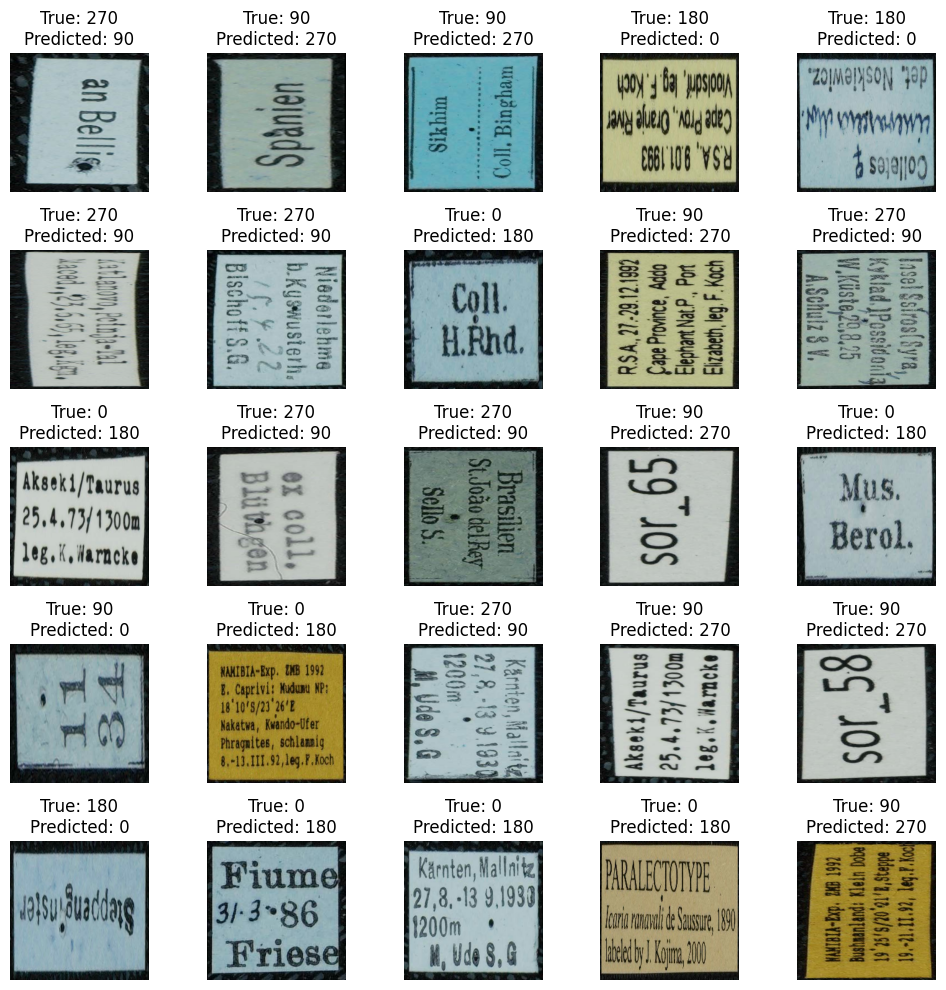

In [ ]:
# Plot learning rate changes
learning_rate = history.history['lr']
plt.plot(learning_rate)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# Get predictions for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

class_labels = ['0', '90', '180', '270', 'empty']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot misclassified images
misclassified_idx = np.where(y_pred_classes != y_true_classes)[0]
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idx[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_val[idx])
    plt.title(f'True: {class_labels[y_true_classes[idx]]}\nPredicted: {class_labels[y_pred_classes[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# Save Model

In [ ]:
# Save the trained model as an HDF5 file
model.save('rotation_model.h5')
print("Trained model saved successfully as rotation_model.h5.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model saved successfully as rotation_model.h5.


# Test model prediction

In [ ]:
# Define constants
TEST_DATA_DIR = 'path to test image set'
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 32
class_labels = ['0', '90', '180', '270', 'empty']

In [ ]:
# Rotate Images Function

def rotate_image(img_path, angle):
    try:
        # Read the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Unable to read image '{img_path}'.")
            return

        # Check if the angle is not 0 or empty
        if angle == 0 or angle == NUM_CLASSES - 1:  # If angle is 0 or empty
            print(f"Skipping image '{img_path}' as it does not need rotation.")
            return

        # Get image dimensions
        height, width = img.shape[:2]

        # Calculate the target angle to rotate the image
        target_angle = (4 - angle) % NUM_CLASSES  # Calculate the required rotation to reach 0 degree

        # Rotate the image around its center
        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), target_angle * 90, 1)

        # Compute the new dimensions of the rotated image
        cos_theta = np.abs(rotation_matrix[0, 0])
        sin_theta = np.abs(rotation_matrix[0, 1])
        new_width = int(height * sin_theta + width * cos_theta)
        new_height = int(height * cos_theta + width * sin_theta)

        # Adjust the rotation matrix to take into account the translation
        rotation_matrix[0, 2] += (new_width - width) / 2
        rotation_matrix[1, 2] += (new_height - height) / 2

        # Perform the rotation with an enlarged canvas
        rotated_img = cv2.warpAffine(img, rotation_matrix, (new_width, new_height))

        # Write the rotated image back to the file
        success = cv2.imwrite(img_path, rotated_img)
        if not success:
            print(f"Error: Failed to write rotated image '{img_path}' to file.")
            return

        print(f"Successfully rotated image '{img_path}' by {target_angle * 90} degrees to reach 0 degree.")
    except Exception as e:
        print(f"Error: An exception occurred while processing image '{img_path}': {e}")

6/6 [==============================] - 1s 100ms/step
Skipping image '/content/drive/My Drive/CollectionMining/rotation/test/0bf98000-aa11-421f-a5d2-38b4b9a2fb41_label_front_0001_label__empty.jpg' as it does not need rotation.
Skipping image '/content/drive/My Drive/CollectionMining/rotation/test/0a7dbadd-0202-4fe0-b922-a5b67c0bd9d0_label_back_0001_label__empty.jpg' as it does not need rotation.
Skipping image '/content/drive/My Drive/CollectionMining/rotation/test/00a7f845-cdbf-4a31-a588-e94df71d94a6_label_back_0001_label__empty.jpg' as it does not need rotation.
Skipping image '/content/drive/My Drive/CollectionMining/rotation/test/0d6a8a63-9bb8-42bf-bca3-32e9052a6bee_label_back_0003_label__empty.jpg' as it does not need rotation.
Skipping image '/content/drive/My Drive/CollectionMining/rotation/test/0a684e39-5dba-4b9c-a884-079c837f9a4f_label_front_0002_label__empty.jpg' as it does not need rotation.
Skipping image '/content/drive/My Drive/CollectionMining/rotation/test/0d8c78f2-6d45-

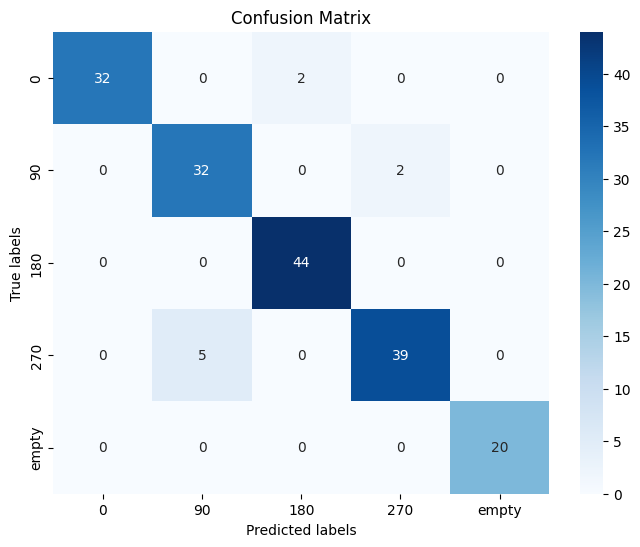

Evaluation Metrics:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-score: 0.95

Weighted Evaluation Metrics:
Weighted Accuracy: 5.22
Weighted Precision: 5.22
Weighted Recall: 5.22
Weighted F1-score: 5.22


In [ ]:
# Load test images and labels
true_labels = np.array([])
loaded_images = []
for img_path in glob(os.path.join(TEST_DATA_DIR, '*.jpg')):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    loaded_images.append(img)

    # Extract angle information from the file name - Ground Truth
    angle_str = img_path.split('__')[-1].split('.')[0]
    if angle_str == 'empty':
        angle = NUM_CLASSES - 1  # Assign the last class index for 'empty'
    else:
        angle = int(angle_str) // 90

    true_labels = np.append(true_labels, angle)  # Append the class label to true_labels

test_images = np.array(loaded_images)  # Convert loaded_images to a NumPy array

# Predict using the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# List all image files in the test data directory
filenames = [os.path.join(TEST_DATA_DIR, filename) for filename in os.listdir(TEST_DATA_DIR) if filename.endswith('.jpg')]

# Apply rotation to images based on their predicted angles
for img_path, predicted_angle in zip(filenames, predicted_labels):
    rotate_image(img_path, predicted_angle)

## Accuracy Metrics and Visualisation

In [ ]:
# Evaluate predictions
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

# Compute class weights and weighted evaluation metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(true_labels), y=true_labels)
weighted_accuracy = np.sum(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * class_weights)
weighted_precision = np.sum(np.diag(conf_matrix) / np.sum(conf_matrix, axis=0) * class_weights)
weighted_recall = np.sum(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * class_weights)
weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nWeighted Evaluation Metrics:")
print(f"Weighted Accuracy: {weighted_accuracy:.2f}")
print(f"Weighted Precision: {weighted_precision:.2f}")
print(f"Weighted Recall: {weighted_recall:.2f}")
print(f"Weighted F1-score: {weighted_f1:.2f}")

## Save Predictions in DataFrame

In [ ]:
# Get filenames
filenames = [os.path.basename(file) for file in glob(os.path.join(TEST_DATA_DIR, '*.jpg'))]

# Create a DataFrame with filenames, true labels, and predicted labels
df = pd.DataFrame({'Filename': filenames, 'True Label': true_labels, 'Predicted Label': predicted_labels})

# Add a column to indicate whether the prediction matches the true label
df['Match'] = (df['True Label'] == df['Predicted Label']).map({True: 'match', False: 'no_match'})

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)

print("Saved Predictions.csv")

Saved Predictions.csv
